# Softmax Classifier (One layer Neural Net)

Autor: Gabriel Dornelles Monteiro, março de 2022. Notebook nº2.



Ao fim deste notebook, você deve ser capaz de entender como funciona o processo completo de uma neural net que utiliza arrays em sua entrada.

Avançando nosso conhecimento, neste notebook veremos todo o pipeline para aproximar uma função que mapeia imagens (matrizes) para probabilidades distribuidas entre classes, bem como seu processo de otimização para de fato aproximar esta função desconhecida.
 


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from torchvision.datasets import CIFAR10
from rich import print


classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Inicialização do dataset
O Dataset é baixado módulo torchvision, que retorna um array de tuplas, cada tupla contendo a imagem como um objeto PIL, e o label associado (PIL.Image, int). Dessa maneira faremos também a conversão dessas imagens e labels para arrays (numpy), os quais podemos operar matematicamente.

In [3]:
train_dataset = CIFAR10(root="./", download=True, train=True) 
val_dataset = CIFAR10(root="./", download=True, train=False) 

Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_images = np.array([np.array(train_dataset[i][0]) for i in range(len(train_dataset))])
train_targets = np.array([np.array(train_dataset[i][1]) for i in range(len(train_dataset))])

val_images = np.array([np.array(val_dataset[i][0]) for i in range(len(val_dataset))])
val_targets = np.array([np.array(val_dataset[i][1]) for i in range(len(val_dataset))])

original_images = val_images

### train_images possui um shape de (50000,32,32,3), ou seja, 50 mil imagens 32x32 RGB, veja algumas delas para se ambientar com o dataset

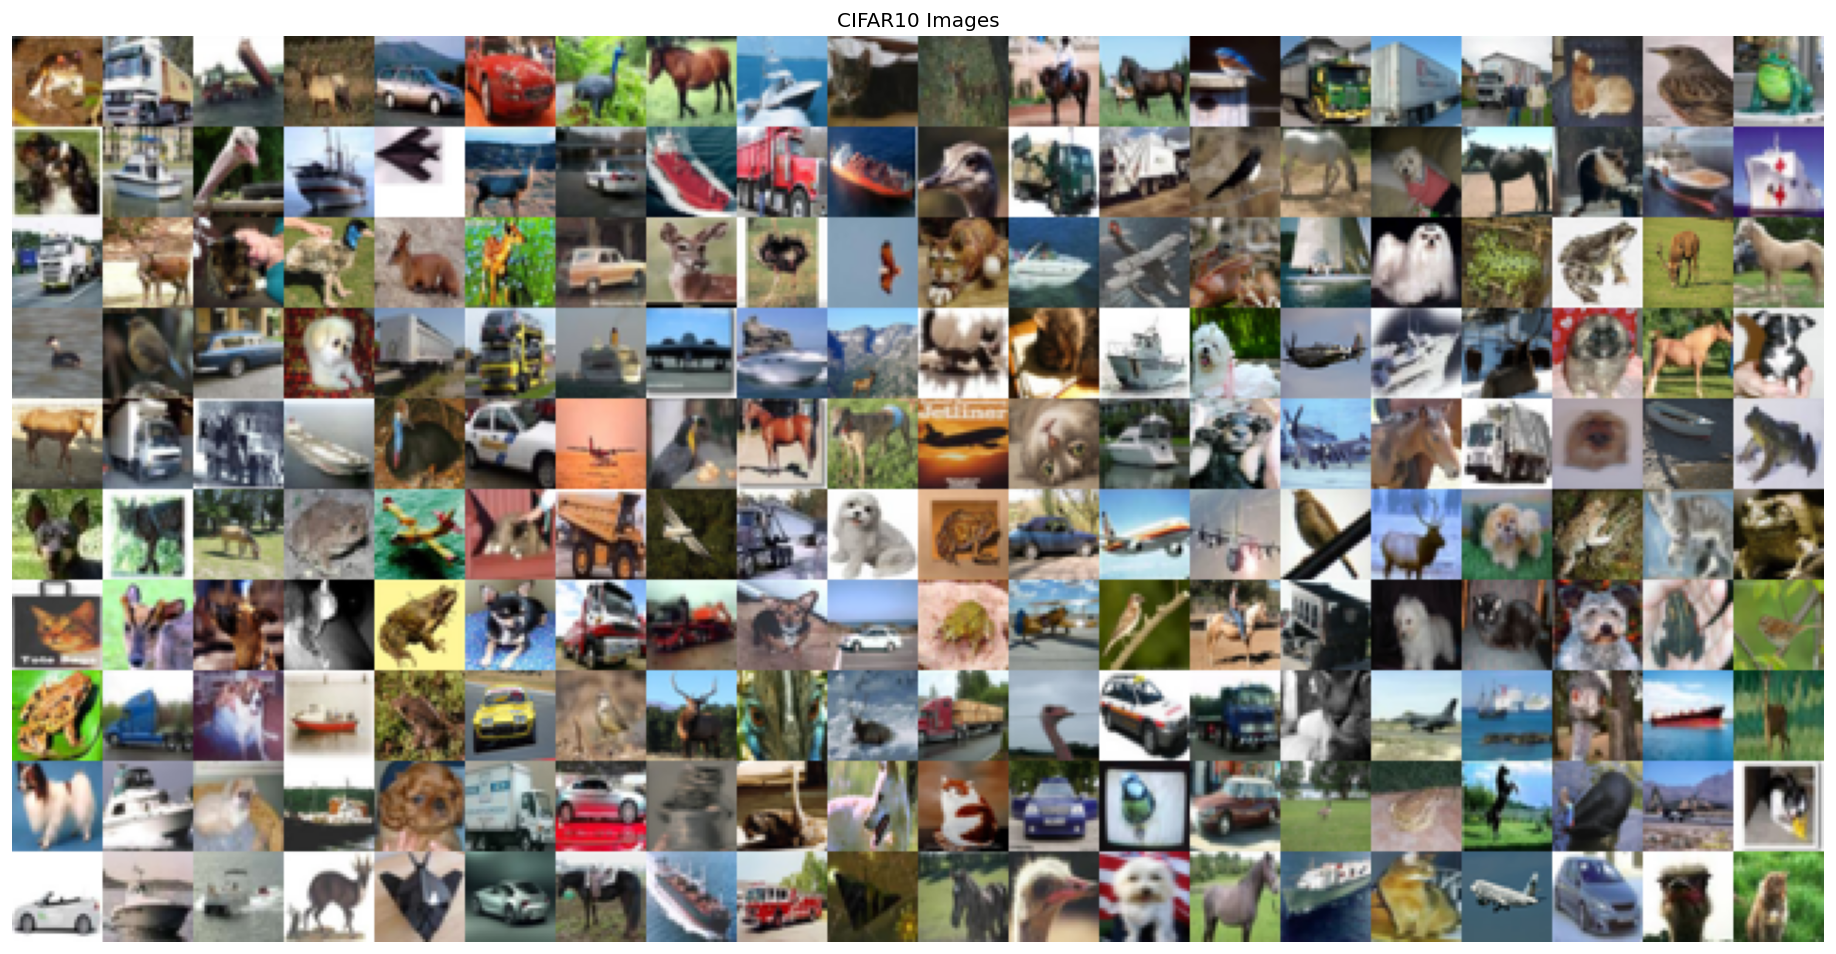

In [6]:
figure(figsize=(20, 10), dpi=120, facecolor="white")
plt.grid(False)
plt.axis(False)

samples = np.vstack([np.hstack(train_images[i:i+20]) for i in range(0,5000,500)])
plt.title("CIFAR10 Images")
plt.imshow(samples)
plt.show()


# Pré processamento
Muitos algoritmos apresentam melhor desempenho quando o conjunto de dados é simétrico (com média zero).

Por que? Considere um caso em que as entradas para um neurônio são todas positivas ou todas negativas:

Nesse caso, o gradiente calculado durante a retropropagação será positivo ou negativo (sendo sempre do mesmo sinal que a entrada no neurônio), portanto, as atualizações de parâmetros são restritas apenas a direções específicas dos neurônios na entrada. Como resultado, as atualizações de gradiente vão longe demais em direções diferentes, dificultando a convergência dos parâmetros para apontarem para o mesmo lugar,o que dificulta a otimização. 

Imagine que alguns parâmetros da nossa matriz estarão sendo atualizados para uma direção, e outros estarão sendo atualizados para outra direção, até que um dos lados comece a ceder e convergir para a direção certa, levará um grande tempo comparado ao dataset que possui média 0, este que já está muito proximo de convergir para a outra direção quando necessário, já que seus valores que eram muito positivos e muito negativos agora tem a mesma distância do zero.

A prática comum é usar a normalização de dados do dataset ImageNet, que é a média calculada através de todo o conjunto de imagens do dataset (1.281.167 imagens), porém ao invés de fazer a média de toda a imagem, pesquisas mostram que os modelos performam melhor quando estas médias são calculadas por canal (R,G e B).
 
Outra prática comum é que cada dimensão é dimensionada adicionalmente por seu desvio padrão, desta maneira, os valores não só estão com a mesma distância do zero, como estão mais proximos do zero, dado que o desvio padrão do ImageNet por canal é (0.229, 0.224, 0.225), o que diminui faz este "squish" nos valores.  (parâmetros mean e std em frameworks/bibliotecas)

- zero-center: subtrair a média de todo o dataset
- normalized: multiplicar pelo desvio padrão

![image](https://user-images.githubusercontent.com/56324869/159142261-1997eebe-a577-4e3f-a74a-0ccd67d50d23.png)


In [8]:
# transforma nossas imagens 32x32x3 em vetor linha 3072
train_images = np.reshape(train_images, (train_images.shape[0], -1))
val_images = np.reshape(val_images, (val_images.shape[0], -1))

# média do array train_images no eixo 0, eixo onde os índices são as imagens 3072
mean_image = np.mean(train_images, axis = 0)

# mean_image é um array de floats, para operação fazer sentido nossas imagens precisam ser também.
train_images = train_images.astype(float)
train_images -= mean_image

val_images = val_images.astype(float)
val_images -= mean_image


print(train_images.shape) # 50 mil imagens 32x32x3 na forma de vetor 1d

(50000, 3072)

# Inicializando nosso modelo e fazendo a primeira inferência
Para inicializar nosso modelo, simplesmente criaremos uma matriz 3072x10 com valores aleatórios.

### Como inicializar?
É sempre melhor que tenhamos o maior número possível de parâmetros sendo levados em conta durante as operações do modelo. Para isso, vejamos os casos: 

- Um modelo possui 50% de precisão usando só metade de seus parâmetros (valores na matriz), e os outros não contribuem para o score (valores como zero).
- Um modelo também com 50% de precisão, mas todos seus parâmetros estão sendo utilizados.

Neste caso, vamos sempre preferir o segundo caso, já que este modelo usa mais pesos, mais características estão sendo levadas em conta para gerar o score.

Por isto, utilizamos a distribuição normal para inicialização dos pesos na nossa matriz W.

## Técnicas para inicializar
---

### Zero initialization
Para esta inicialização, simplesmente inicializamos todos parâmetros como 0. Ao inicializar os pesos em próximos a zero, isso garante que as derivadas vão ser as mesmas para cada valor da matriz W, e com resultado, os neurônios aprendem a mesma quantidade de caracterísitcas em cada iteração (época). O problema desta inicialização é que o modelo falha em quebrar a simetria, se tornando um problema para alcançar qualquer resultado positivo, já que isso é o mesmo que chutar aleatoriamente. 

### Random initialization
Para esta inicialização, simplesmente aplicamos uma multiplicação por um valor próximo a zero a todos os pesos iniciados com a distribuição normal. Desta maneira, o modelo, que agora não irá aprender sempre a mesma quantidade de caracterísitcas para cada classe por cada iteração, deve ser capaz de quebrar a simetria e gerar uma precisão maior que 10%, que para nossas 10 classes é o mesmo que chutar aleatoriamente em alguma delas para todas imagens. 

Essa inicialização deve flutuar em torno de 10% de precisão em sua inicialização, os scores de cada neurônio ainda são quase os mesmos, podendo ser um pouco mais ou um pouco menos que 10% dado a aleatoriedade.

#### Glossário:

- Quebra de Simetria:
    - Na física, a quebra de simetria é um fenômeno no qual (infinitesimalmente) pequenas flutuações atuando em um sistema que cruza um ponto crítico decidem o destino do sistema, determinando qual ramo de uma bifurcação é tomado. 
    
    No nosso caso, a quebra de simetria é o fenômeno que ocorre durante o treinamento, quando o modelo deixa de ter o mesmo aprendizado para todas as classes e passa a aprender caracterísitcas que efetivamente interfiram positivamente no score de cada uma delas.

In [9]:
def zero_initialization():
    W = np.zeros((3072,10))
    return W

def random_initialization():
    W = np.random.randn(3072, 10) * 0.0001
    return W

# Veja o fim do documento caso tenha interesse
def xavier_initialization():
    W = np.random.randn(3072,10) / np.sqrt(3072/2)
    return W

W = random_initialization()

Façamos agora um teste de acurácia da nossa matriz inicializada aleatoriamente

In [11]:
# A partir do python 3.5, é nativo a multiplicação de matrizes através do operador "@" (matmul).
def accuracy(W,X,Y):
    correct = 0

    for i in range(X.shape[0]):
        scores = X[i]@W
        if np.argmax(scores) == Y[i]:
            correct+=1

    return correct/X.shape[0]

print(accuracy(W, val_images, val_targets))

0.1032

É esperado que tenhamos em torno de 10% de acurácia, já que inicializamos nossos pesos de maneira aleatória e toda classe tem a mesma chance de ser escolhida (1/10).

## Softmax
Os valores gerados pelo nosso modelo são puramente resultado da multiplicação (dot product) entre a imagem e os nossos valores aleatórios da matriz. 

Efetivamente, se tratam de simples escalares sem nenhuma interpretação que possamos fazer, como inicializamos a matriz W com valores proximos de zero, esperamos que as saídas sejam simplesmente escalares próximos a 0:

In [148]:
# saida do nosso modelo
val_images[1]@W

array([ 0.10012544, -0.01713963,  0.31892366, -0.57696486, -0.08812144,
        0.42009635, -0.13820522, -0.23265932,  0.14172106,  0.06410436])

A fim de mapear estes valores brutos para probabilidades, aplicamos a função Softmax. 

A função softmax é definida como:

![image](https://user-images.githubusercontent.com/56324869/159147808-2417f387-5f93-4379-81b2-1f1303e0296a.png)

Sendo assim, o nosso pipeline completo do Softmax Classifier finalmente está completo!

![image](https://user-images.githubusercontent.com/56324869/159147785-e63b3848-86da-4cdf-bc0a-11e2e440324b.png)

Neste exemplo é ilustrado o pipeline completo, no fim dele, podemos ver que o indíce da classe com a cor vermelha possui uma certeza de 99%

O código para a função softmax acima:
```py
import numpy as np

scores = np.array([3.5, 2.7, -3.4, -8.7, 9.1, 1.0, -0.7, 3.2])

exp = np.exp(scores)
sum_exp_scores = exp.sum(axis=0, keepdims=True)

normalized = exp / sum_exp_scores
print(normalized) # a soma do array deve ser 1
>>> [3.66683641e-03 1.64761580e-03 3.69538430e-06 1.84458578e-08
 9.91609396e-01 3.00992261e-04 5.49863270e-05 2.71645922e-03]
```

Criamos nossa matriz, inicializamos seus pesos, mapeamos seu resultado para uma probabilidade. E agora, como efetivamente melhoramos esses ~10% de precisão?

# Quantificando o erro
Precisamos de uma métrica para saber o quão errado estava nosso modelo em cada uma das vezes que mapeou uma imagem para uma probabilidade em sua saida, assim como utilizamos o MSE (Mean Squared Error) no exemplo para otimizar nossa aproximação da função seno, agora precisamos de uma maneira de quantificar a distância entre o que nosso modelo diz, e o que ele deveria estar dizendo, uma função que nos diga isso. Esta função se chama **NLL (Negative Log Likelihood)**.

## NLL
Essa função é bastante simples agora que já calculamos nosso array softmax dos scores gerados no array final do modelo. 

A função é simplesmente definida como o log negativo da probabilidade da classe prevista como correta pelo modelo. De maneira formal: 

![image](https://user-images.githubusercontent.com/56324869/159148251-34f8e77f-c431-48b4-b1c2-812e2ba324c9.png)

Loss para um input i = - log base e da probabilidade do label y associado ao input i


## Chain Rule
A essência de todo o processo de otimização esta neste processo que conhecemos como regra da cadeia, vejamos um exemplo de como quebrar uma função em um grafo, e como calcular retroprogagar o erro:

Consideremos uma multiplicação de escalares f(x,y) = xy, neste caso, de maneira intuitiva temos que:

![image](https://user-images.githubusercontent.com/56324869/159167210-3883d893-b711-4f65-bf41-88d86cad309c.png)

Ou seja, a derivada de f em respeito a X, é Y, e a derivada de f em respeito a Y, é X. 

Isso se torna óbvio ao pensarmos que em uma multiplicação, ao alterar um dos valores, o outro responde justamente reagindo a este valor, se X for 4, Y vai reagir com força 4, de maneira positiva. Independente do valor de Y, ele irá crescer 4 vezes, se aumentarmos X para 5, Y irá reagir aumentando 5 vezes.

E se possuirmos mais váriaveis? É então que a regra da cadeia entra, e você provavelmente já a conhece. 

## Vejamos o exemplo para três variáveis

$$ f(x,y,z) = (x+y)z $$

Temos uma nova multiplicação, entre **Z** e a soma de **(x+y)**, de maneira intuitiva podemos repetir o raciocínio e dizer que a derivada de **f** com respeito a **Z**, é simplesmente **(x+y)**, já que o resultado dessa soma influenciará **Z** diretamente com este valor.

Mas vejamos agora, qual a derivada de **f** em respeito a **x**?

Façamos um raciocínio com algumas substituições:

$$ q = x+y $$

e substituiremos **(x+y)** por **q** na função original

$$ f = (x+y)z  $$
$$ f = qz $$


As derivadas de **q** em relação a **x** e **y** são 1, já que **q** é uma soma:
$$ \frac{∂q}{∂x} = 1 $$
$$ \frac{∂q}{∂y} = 1 $$

E as derivadas em respeito a **x** e **y** são **z**:


$$ \frac{∂f}{∂x} = \frac{∂f}{∂q} \frac{∂q}{∂x} = z * 1 = z$$ 
$$ \frac{∂f}{∂y} = \frac{∂f}{∂q} \frac{∂q}{∂y} = z * 1 = z$$ 

## Exemplo da função acima como um grafo
Demos valores a está função para visualizarmos seu funcionamento:
- x = -2
- y = 5
- z = -4

Em verde os valores das operações, e em vermelho, as derivadas de f com respeito a variável

![image](https://user-images.githubusercontent.com/56324869/159168126-c8aee76a-10fd-4adc-a94f-27bf5a91e06f.png)

$$ \frac{∂f}{∂f} = 1 $$

$$ \frac{∂f}{∂z} = (x + y) = 3$$ 

$$ \frac{∂f}{∂q} = z * 1 = - 4 $$

$$ \frac{∂f}{∂x} = \frac{∂f}{∂q} \frac{∂q}{∂x} = -4 * 1 = -4 $$ 
$$ \frac{∂f}{∂y} = \frac{∂f}{∂q} \frac{∂q}{∂y} = -4 * 1 = -4$$ 


Chamamos no caso de **x** por exemplo, que seu **gradiente local** é 1 (dq/dx=1), dado pela operação de soma, e seu **gradiente global** é dado pelo valor calculado no seu nó (nesse caso Q), que é dado por df/dq (-4). 

Na regra da cadeia sempre temos **gradiente local** * **gradiente global**.

--- 
## Derivadas no nosso classificador linear

Nosso forward pass é dado por:


![image](https://user-images.githubusercontent.com/56324869/181937064-bebd69f8-c367-423c-9240-4b1bed934b8b.png)

ou visualizando o código:

![image](https://user-images.githubusercontent.com/56324869/181937089-9bd9db92-3659-47e4-9b2e-54a4183905ef.png)


E nosso backward pass:

![image](https://user-images.githubusercontent.com/56324869/181945449-761fbf19-9518-40c8-b0fc-4673c095f763.png)


Para a derivada da função Softmax em respeito a Loss NLL temos um cálculo um pouco mais elaborado (nada complexo, mas o intuíto deste notebook é outro). Se tiver curiosidade de como chegar nela, você pode ver em detalhes aqui: https://ljvmiranda921.github.io/notebook/2017/08/13/softmax-and-the-negative-log-likelihood/

---

## SGD

O processo de otimização de funções é conhecido como Gradient Descent (GD). É comum no processo de otimizar Neural Nets para imagens que tenhamos problemas para chegar ao minimo da função calculando os gradientes e fazendo seu update para cada imagem do dataset. Para isto, o algoritmo base utilizado para otimização é chamado SGD (Stochastic Gradient Descent), e a única diferença neste é que calculamos os gradientes e fazemos o update baseado em batches de imagens, ou seja, fazemos uma média de n exemplos (16,32,64,128 exemplos etc) e então aplicamos o update.

Para nosso exemplo utilizaremos o dataset inteiro de 50 mil como batch_size, e então faremos uma média do gradiente gerado por todos os exemplos, para então aplicarmos o update.

## L2 Regularization
De maneira prévia, existem muitas combinações que nos dão o mesmo resultado (acertos) no final, todos os múltiplos desses parâmetros (multiplicar toda matriz W por algum valor) nos dão o mesmo resultado. Para evitar essa ambiguidade entre diversos setups de parâmetros que levariam ao mesmo lugar, é adicionado uma penalidade  de regularização. 

Veja: https://cs231n.github.io/linear-classify/ para mais detalhes.

# Entendendo o que é "aprender"
Veja que o **gradiente** , **é um vetor que indica o sentido e a direção na qual obtém-se o maior incremento possível no valor de uma grandeza a partir de (nesse caso) um escalar especificado, que é nossa Loss function (NLL).**

Importante lembrar: O Gradiente aponta a direção de maior **incremento**.


Nossa matriz de pesos é composta por 10 colunas de 3072 valores, ou seja, possuimos 3072 valores para cada uma das 10 classes. O que iremos fazer é ver o em uma imagem o que os pesos aprendidos durante o Backpropagation se parecem, e como eles associam a cada uma das classes na saida. Para isso vamos fazer o reshape de 3072 para 32x32x3, que é a resolução original das imagens do nosso dataset.

Vamos ver o processo de forward para nosso modelo, e como o gradiente se parece, para isso, vamos visualizar como se parece a matriz de pesos que estamos otimizando:

In [14]:
# Método para converter nossa matriz em 10 imagens 32x32x3 
from matplotlib.pyplot import figure
%matplotlib inline

# IMPORTANT: OUR VISUALIZED WEIGHTS ARE NOT IN THE RANGE OF 0-255, but we rescale them to be
# in order to visualize an image. There are negative values and values higher than 255, which
# then we wouldnt be able to interpret as colors.

def plot_weights(w):
    w = w.reshape(32, 32, 3, 10)
    w_min, w_max = np.min(w), np.max(w)
    figure(figsize=(20, 5), dpi=100, facecolor="white")
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        
        # Rescale the weights to be between 0 and 255
        wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
        plt.imshow(wimg.astype('uint8'))
        plt.axis('off')
        plt.title(classes[i])

Neurônios inicializados aleatoriamente

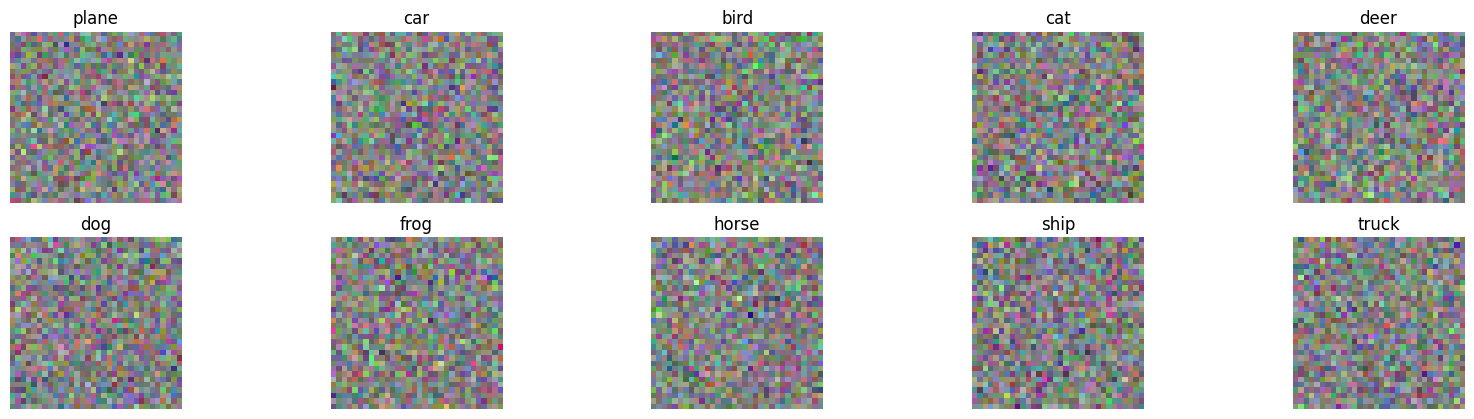

In [15]:
print("Neurônios inicializados aleatoriamente")
plot_weights(W)

Como esperado, nossos pesos inicializados de maneira aleatória são apenas ruído.

Faremos agora um forward + backward pass para calcularmos o gradiente da matriz W:

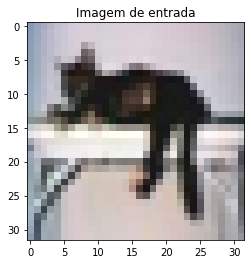

Array normalizado de probabilidades:
[0.12701835392719268, 0.032115427567254745, 0.048112697289793525, 0.07841107611591093, 
0.1436737016966872, 0.24640004249122702, 0.09280436296738513, 0.0715955855547636, 
0.06712522877385077, 0.09274352361593434,]

Loss para a posição 3 do array, neste caso:
-ln(0.078) = 2.546

Array retropropagado (derivada de softmax em respeito a NLL = Pk - 1):
[0.12701835392719268, 0.032115427567254745, 0.048112697289793525, -0.9215889238840891, 
0.1436737016966872, 0.24640004249122702, 0.09280436296738513, 0.0715955855547636, 
0.06712522877385077, 0.09274352361593434,]

In [16]:
i_idx = 1050
plt.figure(facecolor="white")
plt.imshow(original_images[i_idx])
plt.title("Imagem de entrada")
plt.show()

# Init W matrix, declare our input image and its target
W = random_initialization()
target = val_targets[i_idx]
input_image = val_images[i_idx]


# Forward Pass
scores = input_image@W
scores = scores - np.max(scores, axis=0, keepdims=True)
exp = np.exp(scores)
sum_exp_scores = exp.sum(axis=0, keepdims=True)
normalized = exp / sum_exp_scores

# Pretty printing
print_normalized = "["
for i in range(len(normalized)):
    color = "red3" if i==3 else "spring_green1"
    print_normalized += f"[{color}]{normalized[i]}[/{color}], "
print_normalized = print_normalized[:-1] + "]"
print(f"Array normalizado de probabilidades:\n{print_normalized}\n")


# Negative log likelyhood for our input
loss = -np.log(normalized[target])
print(f"Loss para a posição {target} do array, neste caso:\n-ln({normalized[target]:.3f}) = {loss:.3f}\n")

# Pk - 1
normalized_gradient = normalized
normalized_gradient[target] -= 1

# Pretty printing
print_normalized = "["
for i in range(len(normalized)):
    color = "red3" if i==3 else "spring_green1"
    print_normalized += f"[{color}]{normalized_gradient[i]}[/{color}], "
print_normalized = print_normalized[:-1] + "]"
print(f"Array retropropagado (derivada de softmax em respeito a NLL = Pk - 1):\n{print_normalized}")


----
Faremos agora o update com o gradiente:

Note que dW, é dado pela imagem (input) em questão sendo multiplicada por este array que estamos retropropagando com Pk-1, ou seja, cada neurônio (linha do array dW) é dado pela imagem de entrada multiplicada por um escalar, a probabilidade associada a classe no índice que estamos operando.

Perceba que o único elemento que irá sofrer alterações no array softmax é próprio elemento em que o logaritmo operou. 

De maneira intuitiva, nenhum dos outros valores irá ser alterado, dado que eles não contribuem em nada para gerar a loss final.

O valor que aparece na posição 3 do array (dado por Pk-1) se torna um valor negativo, e sua magnitude depende do quão errado a resposta estava. Vejamos o caso Perfeito:

Dado que se a probabilidade for de 100% na classe correta (1),
teremos uma loss function de ln(1)=0, retropropagando, teremos 0-1(Pk-1), entregando -1 no índice associado. Isso significa, que ao realizarmos o cálculo para o gradiente, dado que seu objetivo é **aumentar** o valor da loss function, ele irá justamente inverter o sinal de **todos** elementos que estão gerando este 0 no final.

---------- Atualização para um unico exemplo (utilizando a direção do gradiente) ----------

Array normalizado de probabilidades:
[2.22824988803247e-10, 2.026075675714351e-18, 5.4578604231327416e-17, 7.692231942719882e-93, 
5.104049688264254e-09, 0.9999999946724467, 3.3723388230215984e-13, 5.644679352049817e-15, 
2.3603991057521087e-15, 3.3332983006084457e-13,]

Loss para a posição 3 do array, neste caso:
-ln(7.692231942719882e-93) = 212.1002026674146

Probabilidade associada a classe correta: 7.692231942719882e-93

Classe prevista: dog, confiança: 0.9999999946724467

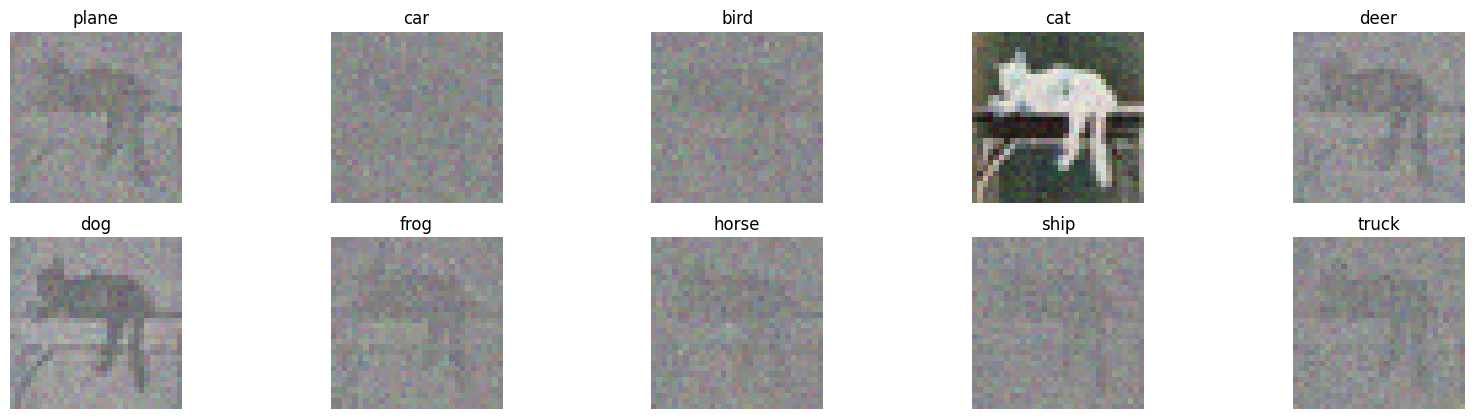

In [17]:
# add axis so matrix algebra works
x = np.expand_dims(val_images[i_idx], axis=1) # (3072,) => (3072, 1) 
normalized_gradient = np.expand_dims(normalized_gradient, axis=1) # (10,) => (10,1)

# Calculate our matrix gradient
dW = x@normalized_gradient.T # 3072x1 * 1x10 = 3072x10

# Apply the gradient
W += dW * 1e-5 

# Forward again and visualize new W neurons
print("\n---------- Atualização para um unico exemplo (utilizando a direção do gradiente) ----------\n")
scores = val_images[i_idx]@W
scores = scores - np.max(scores, axis=0, keepdims=True)
target = val_targets[i_idx]
exp = np.exp(scores)
sum_exp_scores = exp.sum(axis=0, keepdims=True)

normalized = exp / sum_exp_scores

print_normalized = "["
for i in range(len(normalized)):
    color = "red3" if i==3 else "spring_green1"
    print_normalized += f"[{color}]{normalized[i]}[/{color}], "
print_normalized = print_normalized[:-1] + "]"

print(f"Array normalizado de probabilidades:\n{print_normalized}\n")

loss = -np.log(normalized[target])
print(f"Loss para a posição {target} do array, neste caso:\n-ln({normalized[target]}) = {loss}\n")

print(f"Probabilidade associada a classe correta: {normalized[target]}")
print(f"Classe prevista: {classes[np.argmax(normalized)]}, confiança: {normalized[np.argmax(normalized)]}")

plot_weights(W)

Multiplicamos dW por 1e-5 para não vermos o "inf" gerado pelo python para valores muito altos, ja que os expontes negativos se tornam muito altos ao adicionar o gradiente total. 

Naturalmente, o que esperavamos aconteceu, a matriz de pesos, quando recebe o gradiente, gerará um escalar altissimo como loss, que era justamente o objetivo do gradiente, **apontar para a direção de maior incremento**. 


Para isso acontecer, vemos no neurônio (linha da matriz, 3072 valores) da classe associada o inverso da nossa imagem de entrada, o gato preto se tornou branco, o banco, que era branco, se tornou preto.

Lembrando que para visualizarmos os pesos fazemos um rescale para o range de cores RGB (0-255), ao vermos o inverso do gato, nossa interpretação é que os valores desta matriz são justamente valores que tornem a soma e produto no dot product uma grande subtração, subtração essa que gera um valor extremamente negativo, e que torna nossa probabilidade extremamente baixa, que então gera um valor alto como erro (loss).

Veja que o nosso gato também reflete em todas as matrizes de pesos, já que dW é para cada um destes neurônios, nossa imagem de entrada multiplicada pela probabilidade associada, que beirava os 10%, já que iniciamos aleatoriamente, e por isso, a imagem está multiplicada por 0.1, e vemos o gato se formando levemente junto ao ruído inicial.

Como já dito, o algoritmo que utilizamos é chamado Gradient **Descent**, e para isso, nosso objetivo é minimizar a loss function. 

O processo para que isso aconteça é muito simples, invertemos a direção do gradiente utilizando o sinal negativo na frente.

---------- Atualização para um unico exemplo (Gradient Descent) ----------

Array normalizado de probabilidades:
[4.8294414218827866e-82, 8.025102927214436e-78, 5.573606846009977e-78, 1.0, 
1.1754881263982963e-74, 2.8608299239128607e-77, 5.147099141908708e-76, 1.941121175365653e-75,
8.212140484384717e-82, 5.4122570732070225e-77,]

Loss para a posição 3 do array, neste caso:
-ln(1.0) = -0.0

Probabilidade associada a classe correta: 100.0%

Classe prevista: cat, confiança: 1.0

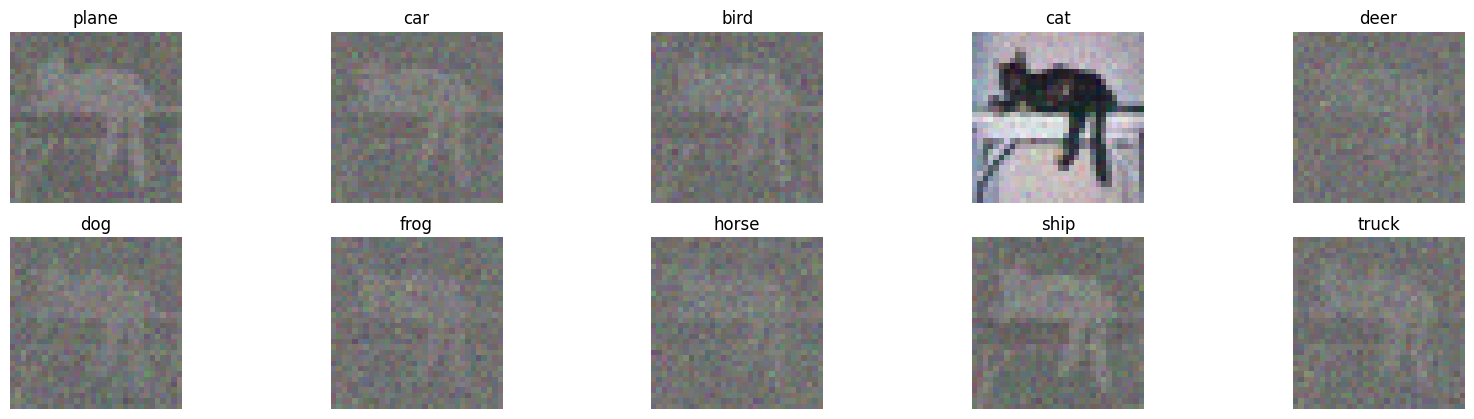

In [18]:
W = random_initialization()
i_idx = 1050
scores = val_images[i_idx]@W
scores = scores - np.max(scores, axis=0, keepdims=True)
target = val_targets[i_idx]
exp = np.exp(scores)
sum_exp_scores = exp.sum(axis=0, keepdims=True)
normalized = exp / sum_exp_scores
loss = -np.log(normalized[target])
normalized_gradient = normalized
normalized_gradient[target] -= 1

x = np.expand_dims(val_images[i_idx], axis=1)
normalized_gradient = np.expand_dims(normalized_gradient, axis=1)
dW = x@normalized_gradient.T

W += dW * -(1e-5)
print("\n---------- Atualização para um unico exemplo (Gradient Descent) ----------\n")
scores = val_images[i_idx]@W
scores = scores - np.max(scores, axis=0, keepdims=True)
target = val_targets[i_idx]
exp = np.exp(scores)
sum_exp_scores = exp.sum(axis=0, keepdims=True)

normalized = exp / sum_exp_scores

print_normalized = "["
for i in range(len(normalized)):
    color = "red3" if i==3 else "spring_green1"
    print_normalized += f"[{color}]{normalized[i]}[/{color}], "
print_normalized = print_normalized[:-1] + "]"

print(f"Array normalizado de probabilidades:\n{print_normalized}\n")

loss = -np.log(normalized[target])
print(f"Loss para a posição {target} do array, neste caso:\n-ln({normalized[target]}) = {loss}\n")

print(f"Probabilidade associada a classe correta: {normalized[target]*100}%")
print(f"Classe prevista: {classes[np.argmax(normalized)]}, confiança: {normalized[np.argmax(normalized)]}")

plot_weights(W)

Com isso, vemos efetivamente o processo de otimização que queriamos, os gatos se refletem nos neurônios, mas dessa vez, temos o template exato do nosso gato na imagem de entrada no neurônio correto, e nosso modelo agora entrega com 100% de confiança, que na imagem temos de fato, um gato. 

Isso por que desta vez, os pesos que deveriam gerar uma grande subtração, são utilizados para gerar uma grande soma, fazendo com que vejamos a exata imagem que entramos no neurônio associado a classe correta, com a adição do ruído, dado que multiplicamos por 1e-5.

# Ao treinamento!

Agora que entendemos o processo de otimização, vamos aplica-lo a todo o CIFAR-10!

Importante: Aplicar o nosso update para cada exemplo é:
1. Muito custoso, dado que teriamos que fazer o processo de calcular as derivadas das funções 50 mil vezes separadas!
2. Imprático, pois nossa matriz irá levar um tempo muuuito maior para convergir para o melhor resultado, e isso se deve ao motivo de que cada exemplo irá aplicar seu template no neurônio, e quando cada um deles vai fazer esse processo, a matriz de pesos já está atualizada com os valores do anterior.

Para isso, treinamos em batches. Neste notebook colocaremos todo o CIFAR-10 em um único batch, no próximo iremos trabalhar com a ideia de batch size!

Note que ainda calculamos as derivadas 50 mil vezes, mas desta vez calculamos tudo em uma única operação, já que X não é mais um vetor de 1x3072, mas sim 50000x3072.

In [19]:
def softmax_loss_vectorized(W : np.array, X : np.array, y : np.array, reg : float = 1e3):
    """
    W: Weights shape: (3072x10)
    X: imagens shape: (batch_size, 3072)
    y: labels shape: (batch_size, 1)
    reg: regularização
    """
    loss = 0.0
    dW = np.zeros_like(W) # inicializa matriz de gradientes
    
    # loss
    num_train = X.shape[0]
    scores = X@W
    scores = scores - np.max(scores, axis=1, keepdims=True) # evita instabilidade numérica
    sum_exp_scores = np.exp(scores).sum(axis=1, keepdims=True)# denominador da equação
    softmax_matrix = np.exp(scores)/sum_exp_scores
    loss = np.sum(-np.log(softmax_matrix[np.arange(num_train), y])) # soma de todas losses para o label associado. É feito a soma para que possa ser feito a média na sequência.
    
    # gradients
    softmax_matrix[np.arange(num_train),y] -= 1 # derivada da função softmax
    dW = X.T@softmax_matrix # operação vetorizada usando análise de dimensões
    
    # Average
    loss /= num_train
    dW /= num_train

    # Regularization
    loss += reg * np.sum(W * W)
    dW += reg * 2 * W 
    return loss, dW


def accuracy_with_softmax(W,X,Y):
    correct = 0

    for i in range(X.shape[0]):
        scores = X[i]@W
        # softmax
        scores = scores - np.max(scores, axis=0, keepdims=True) # evita instabilidade numérica
        sum_exp_scores = np.exp(scores).sum(axis=0, keepdims=True)# denominador da equação
        softmax_matrix = np.exp(scores)/sum_exp_scores
        if np.argmax(softmax_matrix) == Y[i]:
            correct+=1

    return correct/X.shape[0]

def plot_losses(train_losses, graph_title):
    plt.style.use('seaborn')
    train_losses = np.array(train_losses) 
    fig, ax = plt.subplots(figsize = (8, 4.5))
    ax.plot(train_losses, color='red', label="loss") 
    ax.set(title=graph_title, 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    plt.style.use('default')
    plt.show()

### Treinamento do softmax classifier

epoch 0: Loss for the mini-batch: 2.6754753899505324        acc: 0.1829

epoch 50: Loss for the mini-batch: 2.033357401509478        acc: 0.3753

epoch 100: Loss for the mini-batch: 1.9400263274362661        acc: 0.3884

epoch 150: Loss for the mini-batch: 1.8905725182388358        acc: 0.3928

epoch 200: Loss for the mini-batch: 1.8622712127895427        acc: 0.3961

epoch 250: Loss for the mini-batch: 1.845694392089119        acc: 0.3955

epoch 300: Loss for the mini-batch: 1.8358862059977157        acc: 0.397

epoch 350: Loss for the mini-batch: 1.830050521223152        acc: 0.398

epoch 400: Loss for the mini-batch: 1.8265661642314857        acc: 0.3983

epoch 450: Loss for the mini-batch: 1.8244807086732142        acc: 0.3988

best accuracy: 0.3991

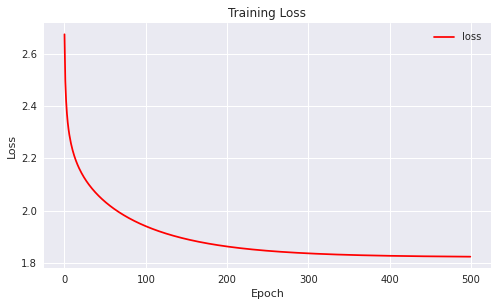

In [20]:
W = random_initialization()

learning_rate = 2.50000e-06
num_epoches = 500 #500
best_acc = 0
losses = []
accs = []

for i in range(num_epoches):
    loss, grad = softmax_loss_vectorized(W, train_images, train_targets, 1e3)
    W +=  grad*(-learning_rate) 
    acc = accuracy(W,val_images,val_targets)
    losses.append(loss)
    accs.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_W = W
    if i%50==0:
        print(f"epoch {i}: Loss for the mini-batch: {loss}        acc: {acc}")

print(f"best accuracy: {best_acc}")
plot_losses(losses, graph_title = "Training Loss")

Para entendermos melhor e interpretarmos os pesos, vamos ver a precisão do nosso modelo por classe

In [21]:
# cria um dicionário com o nome das classes e uma lista contendo as imagens associadas no dataset de validação 
empty_lists = [ [] for _ in range(10)]
classes = ['🛩 plane', '🚗 car', '🐦 bird', '🐈 cat', '🦌 deer', '🦮 dog', '🐸 frog', '🐴 horse', '⛵️ ship', '🚛 truck']
per_class_images = dict(zip(classes,empty_lists))


for idx, image in enumerate(val_images):
    image_target = classes[val_targets[idx]]
    per_class_images[image_target].append(image)

w = best_W
correct = 0
scores_list = []
for idx, class_name in enumerate(classes):
    correct = 0
    for X in per_class_images[class_name]:
        scores = X@w
        # softmax
        scores = scores - np.max(scores, axis=0, keepdims=True) # evita instabilidade numérica
        sum_exp_scores = np.exp(scores).sum(axis=0, keepdims=True)# denominador da equação
        softmax_matrix = np.exp(scores)/sum_exp_scores
        if np.argmax(softmax_matrix) == idx:
            correct+=1
    print(f"{class_name} accuracy: {(correct/1000) * 100:.2f}%")
    scores_list.append((correct/1000) * 100 )

print(f"média dos scores : {np.mean(scores_list):.2f}%")
d = dict(zip(classes, scores_list))

🛩 plane accuracy: 49.20%

🚗 car accuracy: 46.90%

🐦 bird accuracy: 20.00%

🐈 cat accuracy: 21.50%

🦌 deer accuracy: 27.90%

🦮 dog accuracy: 34.60%

🐸 frog accuracy: 54.50%

🐴 horse accuracy: 38.60%

⛵️ ship accuracy: 55.80%

🚛 truck accuracy: 49.90%

média dos scores : 39.89%

## Visualizando o aprendizado do modelo

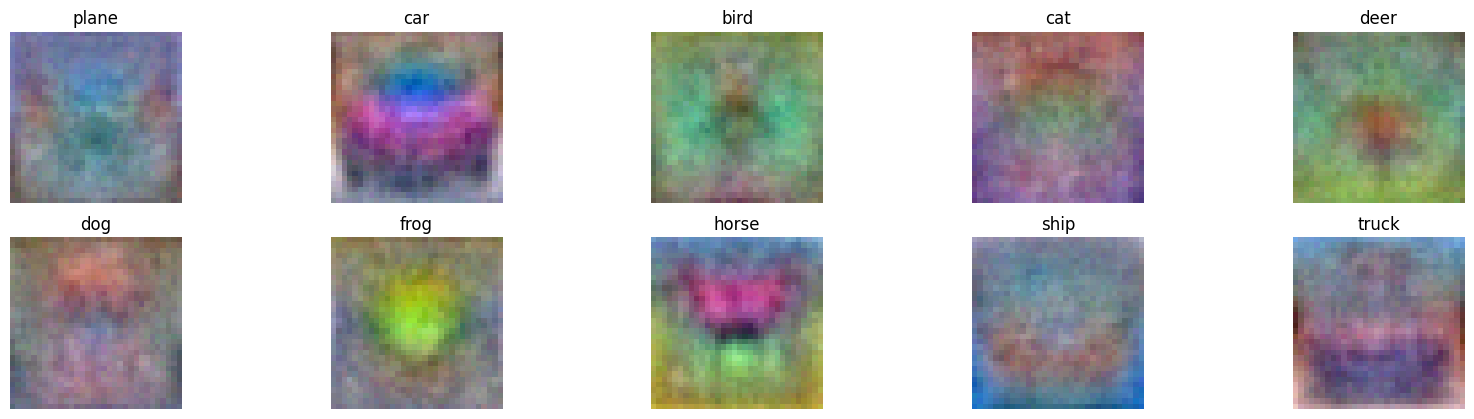

In [22]:
from matplotlib.pyplot import figure
%matplotlib inline

w = best_W 
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)
figure(figsize=(20, 5), dpi=100, facecolor="white")
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

---
nossos scores (do menor para o maior)

In [23]:
from operator import itemgetter

print("Accuracy per class")
for k, v in sorted(d.items(), key=itemgetter(1)):
    print(f"{k}: {v:.2f}%")

Accuracy per class

🐦 bird: 20.00%

🐈 cat: 21.50%

🦌 deer: 27.90%

🦮 dog: 34.60%

🐴 horse: 38.60%

🚗 car: 46.90%

🛩 plane: 49.20%

🚛 truck: 49.90%

🐸 frog: 54.50%

⛵️ ship: 55.80%

Vemos que as maiores precisões estão em ship e frog, acima dos 50%. A classe Ship é a mais fácil de classificar, já que a  matriz de pesos associada tem varios blobs azuis que geram muita ativação devido as imagens de barco estarem sempre associadas com o oceano. 

Na matriz dos sapos, cavalo, e carro, podemos ver algo como uma média destas classes no dataset. o Cavalo parece ser um cavalo olhando para os dois lados, o carro parece ser um carro virado para ambos os lados visto de frente.

Não vemos a média em todas as classes, pois nem todas elas são possíveis de generalizar de uma maneira que seja visual a nós humanos, e tão pouco numericamente como um aprendizado efetivo, dado que o pássaro por exemplo, possui 20% de precisão.

Estas matrizes foram geradas e são o poder máximo do nosso Sofmax classifier com uma camada, ele tenta de certa maneira generalizar em uma unica imagem 32x32x3, a imagem que mais se assemelhe a todas do dataset referentes aquela classe, para que quando elas forem multiplicadas por esse peso, gerem uma maior probabilidade de estar correta!

Nosso modelo tem muitas limitações, por exemplo, um carro visto de lado não terá uma ativação alta, nossa matriz de ativação não contempla isso, ou cavalo visto de costas, ou muitos cenários entre estas classes.

## Como melhorar?
Este modelo possui apenas 10 neurônios, um para cada classe, e ainda é um classificador linear (não possui funções de ativação não lineares). Para nosso próximo experimento iremos adicionar outra camada antes de nossa matriz, e aplicar a função não linear ReLU, se tivermos mais neurônios devemos ser capazes de codificar mais "templates" das imagens, como o carro visto de lado ou o cavalo visto de costa! Até o próximo notebook!



## Técnicas atuais de inicialização de pesos, caso tenha interesse!
----
### Xavier Initialization
Esta é uma abordagem moderna que está presente como inicialização em diferentes módulos de frameworks como o PyTorch. Proposta em 2010 e "corrigida em 2015", ela lida com os problemas da Random Initialization que aparecem ao adicionar mais camadas em nossos modelos.

Quando possuimos mais camadas (6,7,8, n camadas) os gradientes nas ultimas camadas, se inicializadas de maneira aleatória proximos a zero, se tornam lentamente 0, já que o processo que ocorre é algo como 0.1 x 0.1 x 0.1 x 0.1 = 0.0001, o que desascelera muito o aprendizado do modelo, já que as últimas camadas irão estar "lentas" em seu aprendizado, já que seu gradiente é muito próximo de zero, e o seu update muito pequeno.

O contrário também acontece, já que seus pesos forem >1, os gradientes também serão, e algo como 10 x 10 x 10 x 10 = 1000 irá acontecer eventualmente durante o cálculo dos gradientes.

Estes fenômenos são conhecidos como (respectivamente) vanishing gradient e exploding gradient, e em ambos casos, o modelo não consegue convergir para o mínimo da função de erro.

É então que entramos com a inicialização, esta inicialização tem relações principalmente com as funções de ativação utilizadas em cada uma das camadas, essa inicialização possui um trabalho téorico em cima de cada ativação, e a motivação principal é trazer uma variância de aproximadamente 1 para a saida das camadas.

#### He Initialization
Esta inicialização basicamente corrige a inicialização anterior para a função de ativação ReLU (He et al., 2015). 

Kumar (autor da Xavier) prova matemáticamente que para a função ReLU, a melhor inicialização dos pesos é a inicialização aleatória, mas com a variância:

![CodeCogsEqn (3)](https://user-images.githubusercontent.com/56324869/159145834-5e88fe98-7995-493f-831d-e29ab55dff55.png)

Esta, utilizada em [Delving Deep into Rectifiers:
Surpassing Human-Level Performance on ImageNet Classification](https://arxiv.org/pdf/1502.01852v1.pdf), por Kaiming He,  Xiangyu Zhang, Shaoqing Ren e Jian Sun, pesquisadores da Microsoft.

O artigo não se define autor nem cria o termo, e por este motivo o termo He Initialization não é utilizado, mas sim Xavier, dado que no artigo acima é apenas corrigida, de certa forma, a variância para a função de ativação ReLU (até hoje uma das mais utilizadas). Mas é comum ler em códigos fonte como o do PyTorch a escrita relacionada ao autor Kaiming He.

##### Trecho retirado da inicialização do módulo [torch.nn.Linear](https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/linear.py#L96)

![image](https://user-images.githubusercontent.com/56324869/159146108-1a0d0a8f-9534-4879-8f5a-d15b0e52a030.png)

Caso tenha interesse, este é o artigo original onde a inicialização é proposta: [On weight initialization in deep neural networks](https://arxiv.org/abs/1704.08863)